In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/Teeth DataSet.zip','r') as zip:
  zip.extractall()

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import cv2

In [5]:

# Hyperparameters
img_height, img_width = (224, 224)
batch_size = 32
epochs = 40
learning_rate = 0.001

# Data paths
train_dir = 'Teeth_Dataset/Training'
val_dir = 'Teeth_Dataset/Validation'
test_dir = 'Teeth_Dataset/Testing'
# def preprocess_image(image):
#     image = tf.image.central_crop(image, central_fraction=0.875)  # Center crop
#     image = tf.image.resize(image, [224, 224])  # Resize to target size
#     return image
# Data augmentation
datagen = ImageDataGenerator(
    # preprocessing_function=preprocess_image,
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range= 0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
train_generator = datagen.flow_from_directory(train_dir,target_size=(224,224),
                                              batch_size=4,class_mode ='categorical',subset='training')
validation_generator = datagen.flow_from_directory(val_dir,target_size=(224,224),
                                              batch_size=4,class_mode ='categorical',subset='validation')

Found 2471 images belonging to 7 classes.
Found 204 images belonging to 7 classes.


In [6]:
# VGG 16 Model
from tensorflow.keras.applications import VGG16
model_vgg16 = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')
model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Load the pre-trained VGG16 model (include weights if needed)
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l2,l1

input_shape = (224 , 224, 3)  # Replace with the actual shape if different

# Create the input layer
inputs = Input(shape=input_shape)

# Pass the input to the pre-trained model (frozen layers)
x = model_vgg16(inputs)
#x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.1)(x)
outputs = Dense(7, activation='softmax')(x)

# Create the final model
transfer_model = Model(inputs=inputs, outputs=outputs)

transfer_model.layers[1].trainable = False


transfer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,271 (80.64 MB)

 Trainable params: 6,424,583 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Regularization using L2 with hyperparameter tuning
transfer_model.compile(loss='categorical_crossentropy', optimizer='adam',
                        metrics=['accuracy'])

In [9]:
history=transfer_model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


618/618 ━━━━━━━━━━━━━━━━━━━━ 53s 74ms/step - accuracy: 0.3728 - loss: 2.0724 - val_accuracy: 0.3824 - val_loss: 1.5970
Epoch 2/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.5830 - loss: 1.1492 - val_accuracy: 0.4559 - val_loss: 1.7658
Epoch 3/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.6531 - loss: 0.9724 - val_accuracy: 0.4902 - val_loss: 1.6418
Epoch 4/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - accuracy: 0.6790 - loss: 0.8972 - val_accuracy: 0.5490 - val_loss: 1.4049
Epoch 5/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.7222 - loss: 0.7624 - val_accuracy: 0.5441 - val_loss: 1.3957
Epoch 6/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.7418 - loss: 0.7131 - val_accuracy: 0.5245 - val_loss: 1.4620
Epoch 7/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.7523 - loss: 0.6618 - val_accuracy: 0.4755 - val_loss: 1.8422
Epoch 8/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 45s 71ms/step - accuracy: 0.7949 - loss: 0.5950 - val_accurac

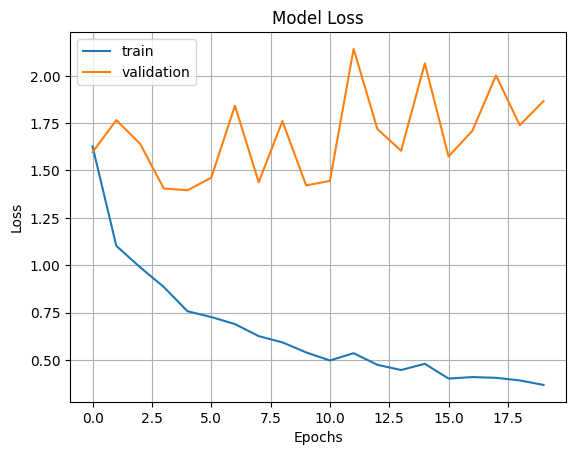

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

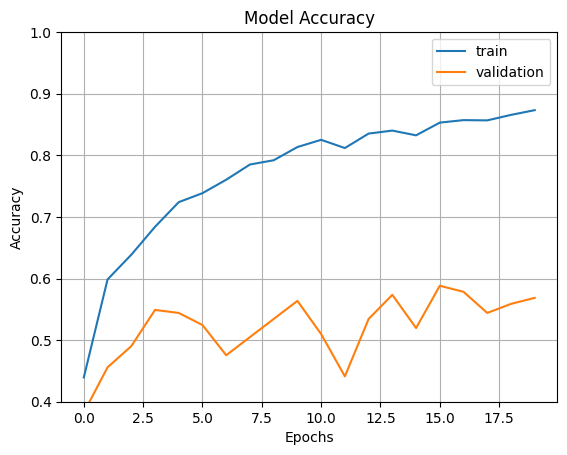

In [11]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
# b7awel

In [12]:
teeth =transfer_model.save('teeth_class_VGG16.h5')

In [13]:
import cv2

img = cv2.imread('/content/Teeth_Dataset/Training/CaS/a_100_0_1462.jpg')
img = cv2.resize(img, (224,224))
img = np.reshape(img, [1,224,224,3])
img = img/255

preds = transfer_model.predict(img)

max_idx = np.argmax(preds)
class_indices = {v:k for k,v in train_generator.class_indices.items()}
class_indices[max_idx]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'CaS'

In [55]:
!pip install streamlit

In [70]:
%%writefile app.py
import streamlit as st

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation=True) # make the func loaded once
def load_model():
  model=tf.keras.models.load_model('teeth_classifier.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Teeth Classification
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):

        size = (224,224)
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.

        img_reshape = img[np.newaxis,...]

        prediction = model.predict(img_reshape)

        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    class_names = ['CaS','CoS','Gum','MC','OC','OLP','OT']
    string = "This image most likely is: "+ class_names[np.argmax(predictions)]
    st.success(string)


Overwriting app.py


In [71]:
!pip install pyngrok

In [72]:
from pyngrok import ngrok
!ngrok authtoken 2lHI4EpeCm3Ch6JAicGlvAjIxQa_cHobUaM1FE7nMePg2RVd

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [73]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.142.225.19:8501

  Stopping...
  Stopping...


In [68]:
!ps aux | grep ngrok

root       12765  0.0  0.0   7376  3452 ?        S    16:58   0:00 /bin/bash -c ps aux | grep ngrok
root       12767  0.0  0.0   6484  2400 ?        S    16:58   0:00 grep ngrok


In [69]:
!kill -9 <PID>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `kill -9 <PID>'


In [51]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.142.225.19:8501

  Stopping...
  Stopping...


In [62]:
!ipython-input-30-5defe3756f26

/bin/bash: line 1: ipython-input-30-5defe3756f26: command not found


In [66]:
!pkill -f ngrok

In [64]:
!ngrok start --all

start - start tunnels by name from the configuration file

USAGE:
  ngrok start [flags]

AUTHOR:
  ngrok - <support@ngrok.com>

COMMANDS: 
  config          update or migrate ngrok's configuration file
  http            start an HTTP tunnel
  tcp             start a TCP tunnel
  tunnel          start a tunnel for use with a tunnel-group backend

EXAMPLES: 
  ngrok http 80                                                 # secure public URL for port 80 web server
  ngrok http --domain baz.ngrok.dev 8080                        # port 8080 available at baz.ngrok.dev
  ngrok tcp 22                                                  # tunnel arbitrary TCP traffic to port 22
  ngrok http 80 --oauth=google --oauth-allow-email=foo@foo.com  # secure your app with oauth

Paid Features: 
  ngrok http 80 --domain mydomain.com                           # run ngrok with your own custom domain
  ngrok http 80 --allow-cidr 2600:8c00::a03c:91ee:fe69:9695/32  # run ngrok with IP policy restrictions
  Upgra

In [74]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [ ]:
from pyngrok import ngrok

# Define the tunnel configuration
tunnel_config = {
    "addr": 8080,  # The port your Streamlit app is running on
    "proto": "http"  # The protocol to use (http or tcp)
}

# Connect with the specified configuration
url = ngrok.connect(**tunnel_config)
print(url)

In [78]:
!cat /content/nohup.out




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.142.225.19:8501

